In [1]:
# 0. Environment Setup
# ------------------------------------------------------------
!pip install --quiet shap joblib imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import joblib
import shap
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style="ticks")

In [2]:
# 1. Load & Clean Data (Robust)
# ------------------------------------------------------------
# Specify the delimiter as semicolon when reading the CSV
df = pd.read_csv("water Quality prediction data set.csv", delimiter=';')

# Normalize column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

# Parse date column if it exists
if "date" in df.columns:
    df["date"] = pd.to_datetime(df["date"], dayfirst=True, errors="coerce")
    df = df.dropna(subset=["date"])
    print("\u2705 'date' column parsed successfully.")
else:
    print("\u26a0\ufe0f 'date' column not found! Available columns:", df.columns.tolist())

# Identify pollutant columns
chem_cols = df.columns.difference(["id", "date"])
# The comparison to < 0 is now applied to the correct numerical columns
df[chem_cols] = df[chem_cols].mask(df[chem_cols] < 0, np.nan)

# Fill missing values
df.fillna(method="ffill", inplace=True)
df.fillna(df[chem_cols].mean(numeric_only=True), inplace=True)

✅ 'date' column parsed successfully.


In [3]:
# 2. WQI Calculation + Class Labels
# ------------------------------------------------------------
weights = {
    "o2": 0.15, "nh4": 0.15, "no3": 0.10, "no2": 0.10,
    "po4": 0.10, "so4": 0.05, "cl": 0.05, "bsk5": 0.15,
    "suspended": 0.15
}

missing = [k for k in weights if k not in df.columns]
if missing:
    raise ValueError(f"Missing columns needed for WQI calculation: {missing}")

min_vals = df[weights.keys()].min()
max_vals = df[weights.keys()].max()
par_norm = df[weights.keys()].sub(min_vals).div(max_vals - min_vals)
df["wqi"] = (100 * (1 - par_norm)).mul(weights).sum(axis=1).astype("float32")

# Create class labels
bins = [-np.inf, 25, 50, 75, 100]
labels = ["Poor", "Marginal", "Fair", "Good"]
df["quality_class"] = pd.cut(df["wqi"], bins=bins, labels=labels)

In [9]:
# 3. Preprocessing & Train-Test Split (Keep All Classes)
# ------------------------------------------------------------
y = df["quality_class"].astype("category")
X = df.drop(["wqi", "quality_class", "date"], axis=1)

# Encode 'id' if present
if "id" in X.columns:
    X["id"] = pd.Categorical(X["id"]).codes

# Do NOT drop rare classes
print("✅ All classes kept. Skipping rare class filtering.")

# Use regular train-test split (no stratify)
train_df, test_df, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Standardize numeric features (excluding 'id')
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_df.drop("id", axis=1))
X_test_scaled = scaler.transform(test_df.drop("id", axis=1))

# Add encoded 'id' back to the scaled features
X_train_preprocessed = np.hstack([X_train_scaled, train_df[["id"]].values])
X_test_preprocessed = np.hstack([X_test_scaled, test_df[["id"]].values])

✅ All classes kept. Skipping rare class filtering.


In [10]:
# 4. Train Random Forest Classifier
# ------------------------------------------------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

clf = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
    max_samples=0.8,
    max_features=0.8
)

clf.fit(X_train_preprocessed, y_train)
pred_clf = clf.predict(X_test_preprocessed)

Test Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

        Good       1.00      1.00      1.00       573

    accuracy                           1.00       573
   macro avg       1.00      1.00      1.00       573
weighted avg       1.00      1.00      1.00       573



<Figure size 600x400 with 0 Axes>

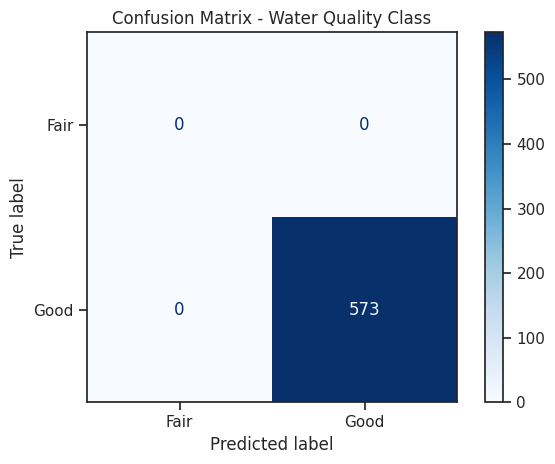

In [11]:
# 5. Evaluation
# ------------------------------------------------------------
accuracy = accuracy_score(y_test, pred_clf)
print(f"Test Accuracy: {accuracy:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, pred_clf))

# Confusion Matrix
labels_sorted = sorted(y.unique())  # Ensure consistent class order
cm = confusion_matrix(y_test, pred_clf, labels=labels_sorted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_sorted)

plt.figure(figsize=(6, 4))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Water Quality Class")
plt.tight_layout()
plt.show()

🔵 Binary classification SHAP output detected.


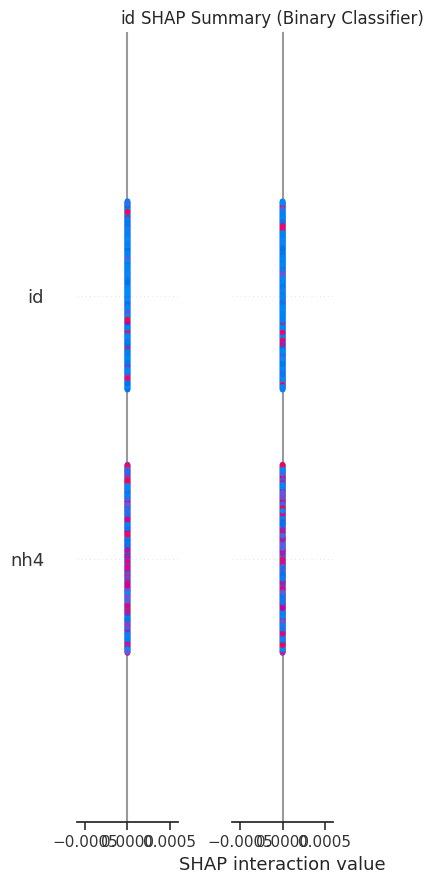

In [12]:
# 6. SHAP Explainability
# ------------------------------------------------------------
import shap

# Sample for SHAP to avoid high memory use
sample_idx = np.random.choice(X_test_preprocessed.shape[0], min(500, X_test_preprocessed.shape[0]), replace=False)
X_sample = X_test_preprocessed[sample_idx]

# Build SHAP explainer
explainer = shap.TreeExplainer(
    clf,
    data=shap.sample(X_train_preprocessed, 100),
    feature_names=list(train_df.columns),
    model_output="raw"
)

shap_values = explainer.shap_values(X_sample)
feature_names = list(train_df.columns)

# Plot per-class SHAP if multi-class
if isinstance(shap_values, list):
    for i, label in enumerate(clf.classes_):
        if hasattr(shap_values[i], "shape") and shap_values[i].ndim == 2:
            plt.figure()
            shap.summary_plot(
                shap_values[i],
                features=X_sample,
                feature_names=feature_names,
                show=False,
                max_display=10,
                plot_size=(8, 6)
            )
            plt.title(f"SHAP Summary for Class '{label}'")
            plt.tight_layout()
            plt.show()
        else:
            print(f"⚠️ Skipping class '{label}' due to unexpected SHAP shape.")
else:
    print("🔵 Binary classification SHAP output detected.")
    shap.summary_plot(
        shap_values,
        features=X_sample,
        feature_names=feature_names,
        show=False,
        max_display=10,
        plot_size=(8, 6)
    )
    plt.title("SHAP Summary (Binary Classifier)")
    plt.tight_layout()
    plt.show()

In [13]:
# 7. Save Model
# ------------------------------------------------------------
import joblib

model_components = {
    "scaler": scaler,
    "model": clf,
    "feature_names": feature_names
}

joblib.dump(model_components, "rf_wqi_quality_classifier_optimized.joblib")
print("✅ Model saved to rf_wqi_quality_classifier_optimized.joblib")

✅ Model saved to rf_wqi_quality_classifier_optimized.joblib
